In [42]:
import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline


pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

In [43]:
data_path = './data/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
pd.set_option("display.max_columns",1000)

In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


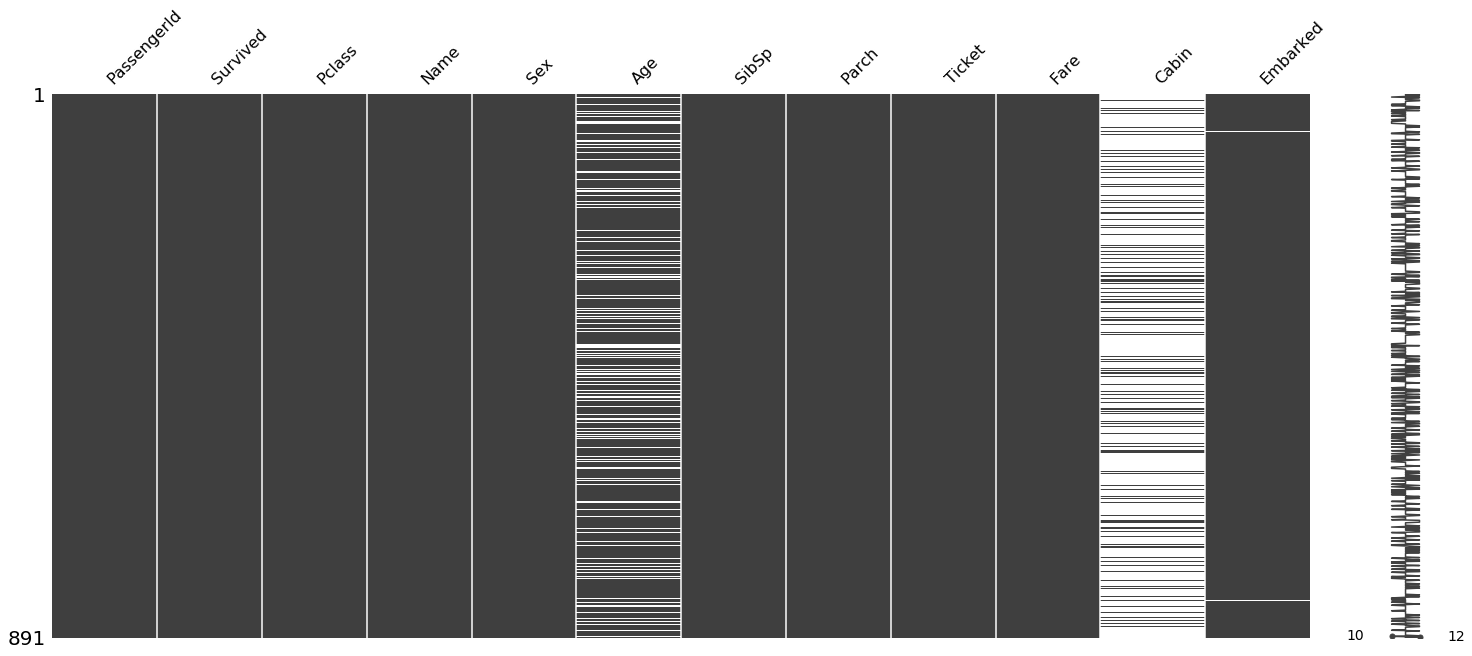

In [46]:
msno.matrix(train)

In [47]:
## 欠損値の数と割合を返す
def missing_columns(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [48]:
missing_columns(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [49]:
missing_columns(test)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [50]:
#Cabinは欠損値が多すぎる、PassengerId、Nameは関係ない、Embarked、Ticketは処理がよくわからないので特徴削除
train = train.drop(columns=['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket'])
test = test.drop(columns=['PassengerId', 'Name', 'Cabin', 'Embarked', 'Ticket'])

In [51]:
#カテゴリ変数の変換
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [52]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [53]:
missing_columns(train)

,Total,Percent
Age,177,19.86532
Fare,0,0.00000
Parch,0,0.00000
SibSp,0,0.00000
Sex,0,0.00000
Pclass,0,0.00000
Survived,0,0.00000


In [54]:
train = train.fillna(train.mean()) # 平均値代入
test = test.fillna(test.mean()) # 平均値代入

In [55]:
missing_columns(train)

,Total,Percent
Fare,0,0.0
Parch,0,0.0
SibSp,0,0.0
Age,0,0.0
Sex,0,0.0
Pclass,0,0.0
Survived,0,0.0


In [56]:
#train data と test data をそれぞれ特徴量とラベルに分ける
from sklearn.model_selection import train_test_split
trainFeatures = train.drop(columns='Survived')
trainLabels = train.Survived

In [57]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [70]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

Training until validation scores don't improve for 100 rounds.
[20]	Train's binary_logloss: 0.577509	Test's binary_logloss: 0.589446
[40]	Train's binary_logloss: 0.526863	Test's binary_logloss: 0.540313
[60]	Train's binary_logloss: 0.5167	Test's binary_logloss: 0.52972
[80]	Train's binary_logloss: 0.502209	Test's binary_logloss: 0.516819
[100]	Train's binary_logloss: 0.494778	Test's binary_logloss: 0.50991
[120]	Train's binary_logloss: 0.481519	Test's binary_logloss: 0.497845
[140]	Train's binary_logloss: 0.46657	Test's binary_logloss: 0.484938
[160]	Train's binary_logloss: 0.47147	Test's binary_logloss: 0.489596
[180]	Train's binary_logloss: 0.450249	Test's binary_logloss: 0.472455
[200]	Train's binary_logloss: 0.433395	Test's binary_logloss: 0.459176
[220]	Train's binary_logloss: 0.425592	Test's binary_logloss: 0.454003
[240]	Train's binary_logloss: 0.414145	Test's binary_logloss: 0.445801
[260]	Train's binary_logloss: 0.405325	Test's binary_logloss: 0.439425
[280]	Train's binary_log

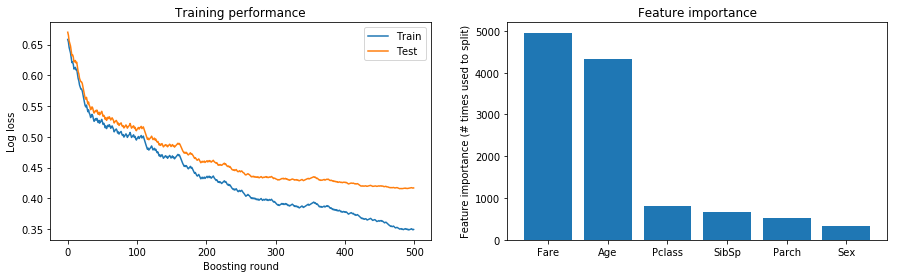

In [71]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [72]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.8547486033519553
Precision score = 	 0.8194444444444444
Recall score =   	 0.8194444444444444
F1 score =      	 0.8194444444444444


In [23]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [24]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
lgbPred = pd.Series(lgbPred)
df_out["Survived"] = lgbPred

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission2.csv",index=False)

In [ ]:
#特徴量選択してもう一回

In [81]:
trainCp = train
testCp = test

In [82]:
trainCp = trainCp.drop(columns=['Parch', 'Sex'])
testCp = testCp.drop(columns=['Parch', 'Sex'])

In [83]:
trainCp.head()

,Survived,Pclass,Age,SibSp,Fare
0,0,3,22.0,1,7.2500
1,1,1,38.0,1,71.2833
2,1,3,26.0,0,7.9250
3,1,1,35.0,1,53.1000
4,0,3,35.0,0,8.0500


In [84]:
#train data と test data をそれぞれ特徴量とラベルに分ける
trainFeatures = trainCp.drop(columns='Survived')
trainLabels = trainCp.Survived

In [85]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [86]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

Training until validation scores don't improve for 100 rounds.
[20]	Train's binary_logloss: 0.616484	Test's binary_logloss: 0.626562
[40]	Train's binary_logloss: 0.593451	Test's binary_logloss: 0.604087
[60]	Train's binary_logloss: 0.588677	Test's binary_logloss: 0.599124
[80]	Train's binary_logloss: 0.581631	Test's binary_logloss: 0.592819
[100]	Train's binary_logloss: 0.579785	Test's binary_logloss: 0.590818
[120]	Train's binary_logloss: 0.575703	Test's binary_logloss: 0.588425
[140]	Train's binary_logloss: 0.570291	Test's binary_logloss: 0.583238
[160]	Train's binary_logloss: 0.57302	Test's binary_logloss: 0.584686
[180]	Train's binary_logloss: 0.562059	Test's binary_logloss: 0.575357
[200]	Train's binary_logloss: 0.554019	Test's binary_logloss: 0.570218
[220]	Train's binary_logloss: 0.549732	Test's binary_logloss: 0.568354
[240]	Train's binary_logloss: 0.542895	Test's binary_logloss: 0.565379
[260]	Train's binary_logloss: 0.538565	Test's binary_logloss: 0.56338
[280]	Train's binary

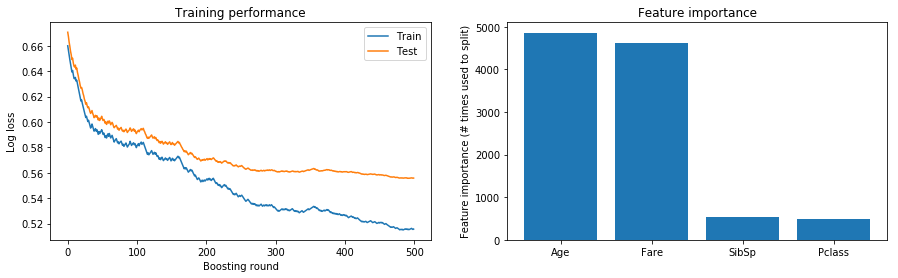

In [87]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [88]:
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.7206703910614525
Precision score = 	 0.7115384615384616
Recall score =   	 0.5138888888888888
F1 score =      	 0.596774193548387
